# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

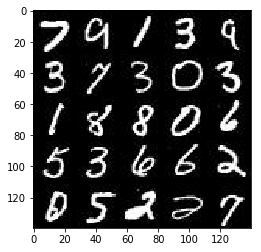

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

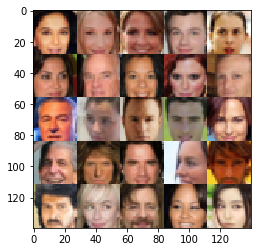

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):        
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(steps, data_shape[0] // batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10/1875... Discriminator Loss: 0.6188... Generator Loss: 1.0818
Epoch 1/2... Batch 20/1875... Discriminator Loss: 0.3159... Generator Loss: 2.7673
Epoch 1/2... Batch 30/1875... Discriminator Loss: 2.2768... Generator Loss: 0.3290
Epoch 1/2... Batch 40/1875... Discriminator Loss: 1.4398... Generator Loss: 3.1433
Epoch 1/2... Batch 50/1875... Discriminator Loss: 2.6775... Generator Loss: 0.1845
Epoch 1/2... Batch 60/1875... Discriminator Loss: 0.7506... Generator Loss: 3.3318
Epoch 1/2... Batch 70/1875... Discriminator Loss: 1.9196... Generator Loss: 0.3646
Epoch 1/2... Batch 80/1875... Discriminator Loss: 1.0598... Generator Loss: 1.0126
Epoch 1/2... Batch 90/1875... Discriminator Loss: 1.0069... Generator Loss: 0.9952
Epoch 1/2... Batch 100/1875... Discriminator Loss: 1.0454... Generator Loss: 0.6624


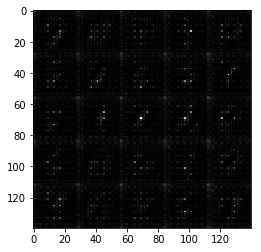

Epoch 1/2... Batch 110/1875... Discriminator Loss: 0.6761... Generator Loss: 0.9801
Epoch 1/2... Batch 120/1875... Discriminator Loss: 0.5789... Generator Loss: 1.1865
Epoch 1/2... Batch 130/1875... Discriminator Loss: 1.1411... Generator Loss: 2.1197
Epoch 1/2... Batch 140/1875... Discriminator Loss: 0.5820... Generator Loss: 1.2510
Epoch 1/2... Batch 150/1875... Discriminator Loss: 0.6606... Generator Loss: 0.9265
Epoch 1/2... Batch 160/1875... Discriminator Loss: 0.2771... Generator Loss: 2.7470
Epoch 1/2... Batch 170/1875... Discriminator Loss: 0.4176... Generator Loss: 1.2702
Epoch 1/2... Batch 180/1875... Discriminator Loss: 0.7626... Generator Loss: 1.0297
Epoch 1/2... Batch 190/1875... Discriminator Loss: 0.1915... Generator Loss: 2.2409
Epoch 1/2... Batch 200/1875... Discriminator Loss: 0.3761... Generator Loss: 1.4252


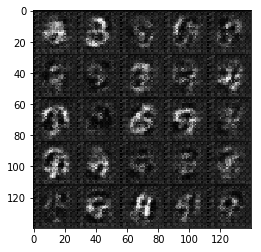

Epoch 1/2... Batch 210/1875... Discriminator Loss: 0.3007... Generator Loss: 4.6980
Epoch 1/2... Batch 220/1875... Discriminator Loss: 0.3587... Generator Loss: 2.2204
Epoch 1/2... Batch 230/1875... Discriminator Loss: 1.3063... Generator Loss: 4.7553
Epoch 1/2... Batch 240/1875... Discriminator Loss: 1.4627... Generator Loss: 4.5740
Epoch 1/2... Batch 250/1875... Discriminator Loss: 0.4250... Generator Loss: 6.4333
Epoch 1/2... Batch 260/1875... Discriminator Loss: 0.6206... Generator Loss: 4.4065
Epoch 1/2... Batch 270/1875... Discriminator Loss: 2.5689... Generator Loss: 4.4693
Epoch 1/2... Batch 280/1875... Discriminator Loss: 0.4598... Generator Loss: 2.6666
Epoch 1/2... Batch 290/1875... Discriminator Loss: 1.0113... Generator Loss: 4.0641
Epoch 1/2... Batch 300/1875... Discriminator Loss: 0.1734... Generator Loss: 3.6549


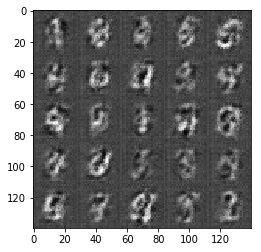

Epoch 1/2... Batch 310/1875... Discriminator Loss: 0.6583... Generator Loss: 0.9093
Epoch 1/2... Batch 320/1875... Discriminator Loss: 0.1568... Generator Loss: 2.7735
Epoch 1/2... Batch 330/1875... Discriminator Loss: 1.1724... Generator Loss: 0.4911
Epoch 1/2... Batch 340/1875... Discriminator Loss: 0.4989... Generator Loss: 1.2979
Epoch 1/2... Batch 350/1875... Discriminator Loss: 0.2077... Generator Loss: 4.0080
Epoch 1/2... Batch 360/1875... Discriminator Loss: 0.4307... Generator Loss: 1.3037
Epoch 1/2... Batch 370/1875... Discriminator Loss: 0.2433... Generator Loss: 2.5459
Epoch 1/2... Batch 380/1875... Discriminator Loss: 0.3312... Generator Loss: 1.7727
Epoch 1/2... Batch 390/1875... Discriminator Loss: 0.2447... Generator Loss: 1.9105
Epoch 1/2... Batch 400/1875... Discriminator Loss: 0.4389... Generator Loss: 1.3462


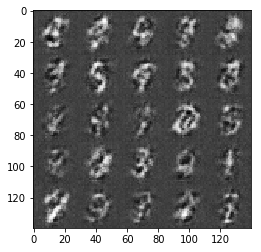

Epoch 1/2... Batch 410/1875... Discriminator Loss: 0.5276... Generator Loss: 1.0716
Epoch 1/2... Batch 420/1875... Discriminator Loss: 0.6096... Generator Loss: 1.0497
Epoch 1/2... Batch 430/1875... Discriminator Loss: 0.3721... Generator Loss: 1.7347
Epoch 1/2... Batch 440/1875... Discriminator Loss: 0.3559... Generator Loss: 1.4442
Epoch 1/2... Batch 450/1875... Discriminator Loss: 0.3195... Generator Loss: 1.9898
Epoch 1/2... Batch 460/1875... Discriminator Loss: 0.2519... Generator Loss: 2.3394
Epoch 1/2... Batch 470/1875... Discriminator Loss: 1.2822... Generator Loss: 0.3802
Epoch 1/2... Batch 480/1875... Discriminator Loss: 0.3247... Generator Loss: 1.7554
Epoch 1/2... Batch 490/1875... Discriminator Loss: 0.3267... Generator Loss: 1.6199
Epoch 1/2... Batch 500/1875... Discriminator Loss: 0.3097... Generator Loss: 1.6229


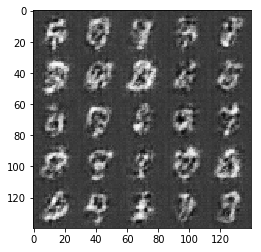

Epoch 1/2... Batch 510/1875... Discriminator Loss: 0.2166... Generator Loss: 2.2327
Epoch 1/2... Batch 520/1875... Discriminator Loss: 0.4613... Generator Loss: 1.3030
Epoch 1/2... Batch 530/1875... Discriminator Loss: 0.3286... Generator Loss: 1.5690
Epoch 1/2... Batch 540/1875... Discriminator Loss: 0.3062... Generator Loss: 1.6991
Epoch 1/2... Batch 550/1875... Discriminator Loss: 0.2793... Generator Loss: 1.8453
Epoch 1/2... Batch 560/1875... Discriminator Loss: 0.2886... Generator Loss: 1.7485
Epoch 1/2... Batch 570/1875... Discriminator Loss: 0.4306... Generator Loss: 1.2410
Epoch 1/2... Batch 580/1875... Discriminator Loss: 0.5755... Generator Loss: 1.3227
Epoch 1/2... Batch 590/1875... Discriminator Loss: 0.7011... Generator Loss: 0.8683
Epoch 1/2... Batch 600/1875... Discriminator Loss: 0.4094... Generator Loss: 1.4963


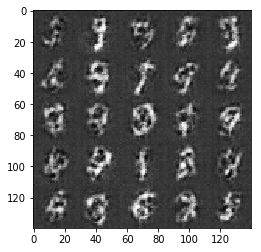

Epoch 1/2... Batch 610/1875... Discriminator Loss: 0.3097... Generator Loss: 1.6646
Epoch 1/2... Batch 620/1875... Discriminator Loss: 0.3667... Generator Loss: 1.5036
Epoch 1/2... Batch 630/1875... Discriminator Loss: 0.5248... Generator Loss: 1.0975
Epoch 1/2... Batch 640/1875... Discriminator Loss: 0.2200... Generator Loss: 2.0665
Epoch 1/2... Batch 650/1875... Discriminator Loss: 0.3314... Generator Loss: 1.5280
Epoch 1/2... Batch 660/1875... Discriminator Loss: 0.1644... Generator Loss: 2.4394
Epoch 1/2... Batch 670/1875... Discriminator Loss: 0.2545... Generator Loss: 1.9014
Epoch 1/2... Batch 680/1875... Discriminator Loss: 0.2916... Generator Loss: 1.6666
Epoch 1/2... Batch 690/1875... Discriminator Loss: 0.3447... Generator Loss: 1.4731
Epoch 1/2... Batch 700/1875... Discriminator Loss: 0.3364... Generator Loss: 1.6062


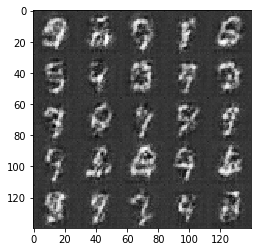

Epoch 1/2... Batch 710/1875... Discriminator Loss: 0.3543... Generator Loss: 1.5910
Epoch 1/2... Batch 720/1875... Discriminator Loss: 0.1339... Generator Loss: 2.7308
Epoch 1/2... Batch 730/1875... Discriminator Loss: 0.3029... Generator Loss: 1.6453
Epoch 1/2... Batch 740/1875... Discriminator Loss: 0.1184... Generator Loss: 2.7328
Epoch 1/2... Batch 750/1875... Discriminator Loss: 0.2031... Generator Loss: 2.0160
Epoch 1/2... Batch 760/1875... Discriminator Loss: 8.1939... Generator Loss: 0.0030
Epoch 1/2... Batch 770/1875... Discriminator Loss: 0.2389... Generator Loss: 2.3547
Epoch 1/2... Batch 780/1875... Discriminator Loss: 0.3086... Generator Loss: 2.0987
Epoch 1/2... Batch 790/1875... Discriminator Loss: 0.3894... Generator Loss: 1.4444
Epoch 1/2... Batch 800/1875... Discriminator Loss: 0.3498... Generator Loss: 1.7923


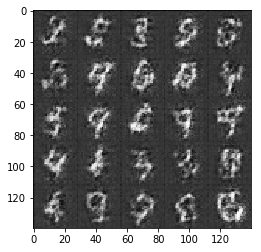

Epoch 1/2... Batch 810/1875... Discriminator Loss: 0.4916... Generator Loss: 1.1684
Epoch 1/2... Batch 820/1875... Discriminator Loss: 0.1362... Generator Loss: 2.6561
Epoch 1/2... Batch 830/1875... Discriminator Loss: 0.1890... Generator Loss: 2.5575
Epoch 1/2... Batch 840/1875... Discriminator Loss: 0.2712... Generator Loss: 1.8075
Epoch 1/2... Batch 850/1875... Discriminator Loss: 0.4621... Generator Loss: 1.2170
Epoch 1/2... Batch 860/1875... Discriminator Loss: 0.3741... Generator Loss: 1.5742
Epoch 1/2... Batch 870/1875... Discriminator Loss: 0.2069... Generator Loss: 1.9575
Epoch 1/2... Batch 880/1875... Discriminator Loss: 0.2039... Generator Loss: 2.0293
Epoch 1/2... Batch 890/1875... Discriminator Loss: 0.1686... Generator Loss: 2.3153
Epoch 1/2... Batch 900/1875... Discriminator Loss: 0.1819... Generator Loss: 2.1104


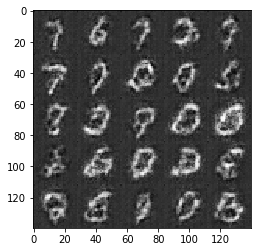

Epoch 1/2... Batch 910/1875... Discriminator Loss: 0.8936... Generator Loss: 5.8363
Epoch 1/2... Batch 920/1875... Discriminator Loss: 0.4042... Generator Loss: 1.5024
Epoch 1/2... Batch 930/1875... Discriminator Loss: 0.6316... Generator Loss: 0.9494
Epoch 1/2... Batch 940/1875... Discriminator Loss: 0.3610... Generator Loss: 1.5339
Epoch 1/2... Batch 950/1875... Discriminator Loss: 0.3467... Generator Loss: 1.6391
Epoch 1/2... Batch 960/1875... Discriminator Loss: 0.2647... Generator Loss: 1.6970
Epoch 1/2... Batch 970/1875... Discriminator Loss: 0.2629... Generator Loss: 1.9267
Epoch 1/2... Batch 980/1875... Discriminator Loss: 0.2933... Generator Loss: 1.7111
Epoch 1/2... Batch 990/1875... Discriminator Loss: 0.2635... Generator Loss: 1.6564
Epoch 1/2... Batch 1000/1875... Discriminator Loss: 0.3263... Generator Loss: 1.4452


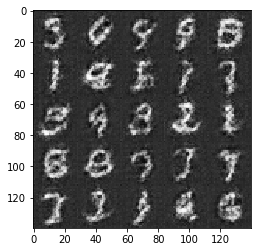

Epoch 1/2... Batch 1010/1875... Discriminator Loss: 0.3144... Generator Loss: 1.6246
Epoch 1/2... Batch 1020/1875... Discriminator Loss: 0.1168... Generator Loss: 2.8664
Epoch 1/2... Batch 1030/1875... Discriminator Loss: 0.0963... Generator Loss: 2.7444
Epoch 1/2... Batch 1040/1875... Discriminator Loss: 0.1865... Generator Loss: 2.1048
Epoch 1/2... Batch 1050/1875... Discriminator Loss: 0.2255... Generator Loss: 2.0926
Epoch 1/2... Batch 1060/1875... Discriminator Loss: 0.1236... Generator Loss: 2.6281
Epoch 1/2... Batch 1070/1875... Discriminator Loss: 0.0483... Generator Loss: 4.2742
Epoch 1/2... Batch 1080/1875... Discriminator Loss: 0.2121... Generator Loss: 1.9770
Epoch 1/2... Batch 1090/1875... Discriminator Loss: 0.5616... Generator Loss: 1.0345
Epoch 1/2... Batch 1100/1875... Discriminator Loss: 0.3781... Generator Loss: 1.3171


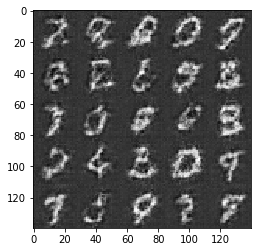

Epoch 1/2... Batch 1110/1875... Discriminator Loss: 0.1732... Generator Loss: 2.0727
Epoch 1/2... Batch 1120/1875... Discriminator Loss: 0.0739... Generator Loss: 3.4126
Epoch 1/2... Batch 1130/1875... Discriminator Loss: 0.2314... Generator Loss: 1.8341
Epoch 1/2... Batch 1140/1875... Discriminator Loss: 0.1763... Generator Loss: 2.2645
Epoch 1/2... Batch 1150/1875... Discriminator Loss: 0.0999... Generator Loss: 2.9777
Epoch 1/2... Batch 1160/1875... Discriminator Loss: 0.1100... Generator Loss: 2.5574
Epoch 1/2... Batch 1170/1875... Discriminator Loss: 0.1646... Generator Loss: 2.2229
Epoch 1/2... Batch 1180/1875... Discriminator Loss: 0.4183... Generator Loss: 1.2721
Epoch 1/2... Batch 1190/1875... Discriminator Loss: 0.0517... Generator Loss: 4.2185
Epoch 1/2... Batch 1200/1875... Discriminator Loss: 0.0547... Generator Loss: 3.5738


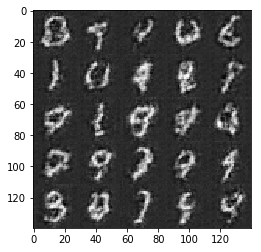

Epoch 1/2... Batch 1210/1875... Discriminator Loss: 0.0412... Generator Loss: 4.2289
Epoch 1/2... Batch 1220/1875... Discriminator Loss: 0.0682... Generator Loss: 3.3371
Epoch 1/2... Batch 1230/1875... Discriminator Loss: 0.0447... Generator Loss: 3.7111
Epoch 1/2... Batch 1240/1875... Discriminator Loss: 0.0754... Generator Loss: 3.1945
Epoch 1/2... Batch 1250/1875... Discriminator Loss: 0.0394... Generator Loss: 3.8436
Epoch 1/2... Batch 1260/1875... Discriminator Loss: 0.9663... Generator Loss: 1.3355
Epoch 1/2... Batch 1270/1875... Discriminator Loss: 1.0144... Generator Loss: 0.9730
Epoch 1/2... Batch 1280/1875... Discriminator Loss: 1.6370... Generator Loss: 0.4137
Epoch 1/2... Batch 1290/1875... Discriminator Loss: 1.6737... Generator Loss: 0.3607
Epoch 1/2... Batch 1300/1875... Discriminator Loss: 0.8051... Generator Loss: 0.9989


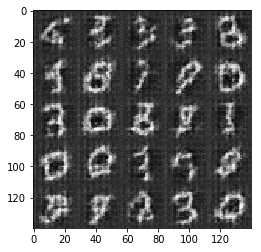

Epoch 1/2... Batch 1310/1875... Discriminator Loss: 1.0403... Generator Loss: 0.8228
Epoch 1/2... Batch 1320/1875... Discriminator Loss: 0.8250... Generator Loss: 0.9760
Epoch 1/2... Batch 1330/1875... Discriminator Loss: 0.9519... Generator Loss: 0.9412
Epoch 1/2... Batch 1340/1875... Discriminator Loss: 0.7156... Generator Loss: 1.1378
Epoch 1/2... Batch 1350/1875... Discriminator Loss: 0.8620... Generator Loss: 0.8137
Epoch 1/2... Batch 1360/1875... Discriminator Loss: 1.0817... Generator Loss: 3.1301
Epoch 1/2... Batch 1370/1875... Discriminator Loss: 1.0258... Generator Loss: 3.6470
Epoch 1/2... Batch 1380/1875... Discriminator Loss: 0.5870... Generator Loss: 1.8233
Epoch 1/2... Batch 1390/1875... Discriminator Loss: 0.7550... Generator Loss: 0.8217
Epoch 1/2... Batch 1400/1875... Discriminator Loss: 0.6005... Generator Loss: 1.3574


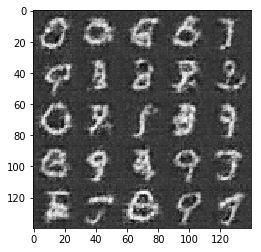

Epoch 1/2... Batch 1410/1875... Discriminator Loss: 0.3092... Generator Loss: 1.9776
Epoch 1/2... Batch 1420/1875... Discriminator Loss: 1.6170... Generator Loss: 0.3853
Epoch 1/2... Batch 1430/1875... Discriminator Loss: 0.4327... Generator Loss: 1.3559
Epoch 1/2... Batch 1440/1875... Discriminator Loss: 0.3175... Generator Loss: 2.0423
Epoch 1/2... Batch 1450/1875... Discriminator Loss: 0.2461... Generator Loss: 2.1976
Epoch 1/2... Batch 1460/1875... Discriminator Loss: 0.2741... Generator Loss: 2.1998
Epoch 1/2... Batch 1470/1875... Discriminator Loss: 0.3061... Generator Loss: 3.2905
Epoch 1/2... Batch 1480/1875... Discriminator Loss: 0.3294... Generator Loss: 1.7092
Epoch 1/2... Batch 1490/1875... Discriminator Loss: 0.5378... Generator Loss: 1.1641
Epoch 1/2... Batch 1500/1875... Discriminator Loss: 0.4204... Generator Loss: 1.4030


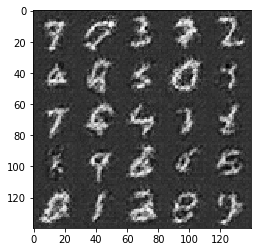

Epoch 1/2... Batch 1510/1875... Discriminator Loss: 0.3581... Generator Loss: 1.5118
Epoch 1/2... Batch 1520/1875... Discriminator Loss: 0.5880... Generator Loss: 1.0296
Epoch 1/2... Batch 1530/1875... Discriminator Loss: 0.2171... Generator Loss: 2.0646
Epoch 1/2... Batch 1540/1875... Discriminator Loss: 0.1815... Generator Loss: 2.1815
Epoch 1/2... Batch 1550/1875... Discriminator Loss: 0.2394... Generator Loss: 1.9389
Epoch 1/2... Batch 1560/1875... Discriminator Loss: 0.2317... Generator Loss: 1.8212
Epoch 1/2... Batch 1570/1875... Discriminator Loss: 0.0829... Generator Loss: 2.9496
Epoch 1/2... Batch 1580/1875... Discriminator Loss: 0.0553... Generator Loss: 3.5091
Epoch 1/2... Batch 1590/1875... Discriminator Loss: 0.0171... Generator Loss: 5.2497
Epoch 1/2... Batch 1600/1875... Discriminator Loss: 0.3004... Generator Loss: 1.5648


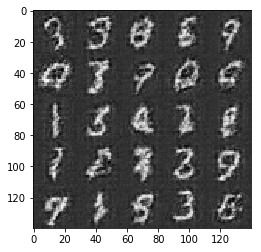

Epoch 1/2... Batch 1610/1875... Discriminator Loss: 0.1065... Generator Loss: 2.8451
Epoch 1/2... Batch 1620/1875... Discriminator Loss: 0.0830... Generator Loss: 4.5377
Epoch 1/2... Batch 1630/1875... Discriminator Loss: 0.0649... Generator Loss: 3.3748
Epoch 1/2... Batch 1640/1875... Discriminator Loss: 0.0291... Generator Loss: 4.5332
Epoch 1/2... Batch 1650/1875... Discriminator Loss: 0.2630... Generator Loss: 1.8276
Epoch 1/2... Batch 1660/1875... Discriminator Loss: 0.0567... Generator Loss: 3.6980
Epoch 1/2... Batch 1670/1875... Discriminator Loss: 0.0871... Generator Loss: 3.3865
Epoch 1/2... Batch 1680/1875... Discriminator Loss: 0.2966... Generator Loss: 1.6132
Epoch 1/2... Batch 1690/1875... Discriminator Loss: 0.1303... Generator Loss: 2.3578
Epoch 1/2... Batch 1700/1875... Discriminator Loss: 0.2335... Generator Loss: 1.8900


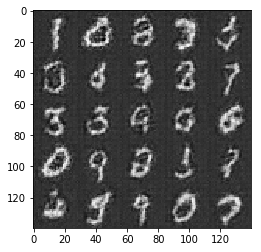

Epoch 1/2... Batch 1710/1875... Discriminator Loss: 0.1250... Generator Loss: 2.6706
Epoch 1/2... Batch 1720/1875... Discriminator Loss: 0.0297... Generator Loss: 4.5002
Epoch 1/2... Batch 1730/1875... Discriminator Loss: 0.0252... Generator Loss: 5.3264
Epoch 1/2... Batch 1740/1875... Discriminator Loss: 0.1414... Generator Loss: 2.3968
Epoch 1/2... Batch 1750/1875... Discriminator Loss: 0.2678... Generator Loss: 1.7474
Epoch 1/2... Batch 1760/1875... Discriminator Loss: 0.1242... Generator Loss: 2.6262
Epoch 1/2... Batch 1770/1875... Discriminator Loss: 0.0236... Generator Loss: 4.5802
Epoch 1/2... Batch 1780/1875... Discriminator Loss: 0.0502... Generator Loss: 3.9817
Epoch 1/2... Batch 1790/1875... Discriminator Loss: 0.3056... Generator Loss: 1.6498
Epoch 1/2... Batch 1800/1875... Discriminator Loss: 0.0386... Generator Loss: 4.1114


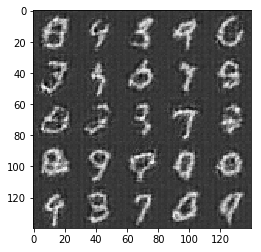

Epoch 1/2... Batch 1810/1875... Discriminator Loss: 0.0731... Generator Loss: 3.1131
Epoch 1/2... Batch 1820/1875... Discriminator Loss: 0.0455... Generator Loss: 3.6905
Epoch 1/2... Batch 1830/1875... Discriminator Loss: 4.8041... Generator Loss: 0.0678
Epoch 1/2... Batch 1840/1875... Discriminator Loss: 0.6501... Generator Loss: 1.4538
Epoch 1/2... Batch 1850/1875... Discriminator Loss: 0.5496... Generator Loss: 2.2039
Epoch 1/2... Batch 1860/1875... Discriminator Loss: 0.5489... Generator Loss: 1.7350
Epoch 1/2... Batch 1870/1875... Discriminator Loss: 0.4715... Generator Loss: 1.8737
Epoch 2/2... Batch 10/1875... Discriminator Loss: 0.2809... Generator Loss: 2.1552
Epoch 2/2... Batch 20/1875... Discriminator Loss: 0.4570... Generator Loss: 1.5474
Epoch 2/2... Batch 30/1875... Discriminator Loss: 0.2944... Generator Loss: 2.2838
Epoch 2/2... Batch 40/1875... Discriminator Loss: 0.8959... Generator Loss: 0.8983
Epoch 2/2... Batch 50/1875... Discriminator Loss: 0.5591... Generator Los

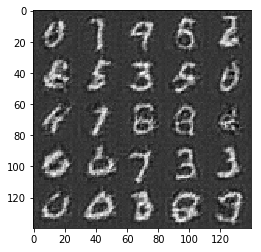

Epoch 2/2... Batch 110/1875... Discriminator Loss: 0.3631... Generator Loss: 1.6147
Epoch 2/2... Batch 120/1875... Discriminator Loss: 0.3521... Generator Loss: 1.4695
Epoch 2/2... Batch 130/1875... Discriminator Loss: 0.2465... Generator Loss: 2.1882
Epoch 2/2... Batch 140/1875... Discriminator Loss: 0.2145... Generator Loss: 2.1734
Epoch 2/2... Batch 150/1875... Discriminator Loss: 0.2710... Generator Loss: 2.0217
Epoch 2/2... Batch 160/1875... Discriminator Loss: 0.0670... Generator Loss: 3.4207
Epoch 2/2... Batch 170/1875... Discriminator Loss: 0.0646... Generator Loss: 3.6984
Epoch 2/2... Batch 180/1875... Discriminator Loss: 0.0508... Generator Loss: 3.6969
Epoch 2/2... Batch 190/1875... Discriminator Loss: 0.0257... Generator Loss: 4.2955
Epoch 2/2... Batch 200/1875... Discriminator Loss: 0.0582... Generator Loss: 3.5170


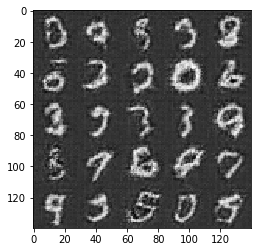

Epoch 2/2... Batch 210/1875... Discriminator Loss: 0.0369... Generator Loss: 5.5621
Epoch 2/2... Batch 220/1875... Discriminator Loss: 0.1600... Generator Loss: 2.2455
Epoch 2/2... Batch 230/1875... Discriminator Loss: 0.1374... Generator Loss: 2.3771
Epoch 2/2... Batch 240/1875... Discriminator Loss: 0.0420... Generator Loss: 4.1468
Epoch 2/2... Batch 250/1875... Discriminator Loss: 0.1910... Generator Loss: 2.1304
Epoch 2/2... Batch 260/1875... Discriminator Loss: 0.0799... Generator Loss: 3.3872
Epoch 2/2... Batch 270/1875... Discriminator Loss: 1.8971... Generator Loss: 8.1022
Epoch 2/2... Batch 280/1875... Discriminator Loss: 0.7814... Generator Loss: 1.5333
Epoch 2/2... Batch 290/1875... Discriminator Loss: 0.7800... Generator Loss: 1.2609
Epoch 2/2... Batch 300/1875... Discriminator Loss: 0.6246... Generator Loss: 1.2221


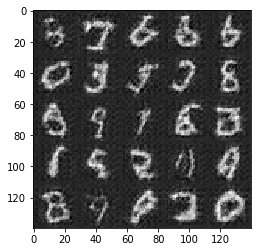

Epoch 2/2... Batch 310/1875... Discriminator Loss: 1.1942... Generator Loss: 0.5842
Epoch 2/2... Batch 320/1875... Discriminator Loss: 0.7702... Generator Loss: 0.8850
Epoch 2/2... Batch 330/1875... Discriminator Loss: 0.5382... Generator Loss: 1.8432
Epoch 2/2... Batch 340/1875... Discriminator Loss: 0.4978... Generator Loss: 1.6361
Epoch 2/2... Batch 350/1875... Discriminator Loss: 0.5342... Generator Loss: 2.4866
Epoch 2/2... Batch 360/1875... Discriminator Loss: 0.6675... Generator Loss: 1.3303
Epoch 2/2... Batch 370/1875... Discriminator Loss: 0.5058... Generator Loss: 1.3408
Epoch 2/2... Batch 380/1875... Discriminator Loss: 0.9441... Generator Loss: 4.7859
Epoch 2/2... Batch 390/1875... Discriminator Loss: 0.3889... Generator Loss: 2.0508
Epoch 2/2... Batch 400/1875... Discriminator Loss: 0.5094... Generator Loss: 2.8458


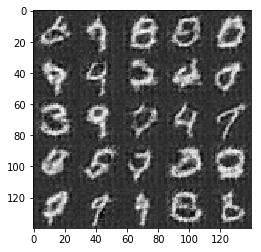

Epoch 2/2... Batch 410/1875... Discriminator Loss: 0.3016... Generator Loss: 2.8593
Epoch 2/2... Batch 420/1875... Discriminator Loss: 0.3732... Generator Loss: 2.1329
Epoch 2/2... Batch 430/1875... Discriminator Loss: 0.3802... Generator Loss: 3.7315
Epoch 2/2... Batch 440/1875... Discriminator Loss: 0.5915... Generator Loss: 1.0360
Epoch 2/2... Batch 450/1875... Discriminator Loss: 0.2596... Generator Loss: 2.1097
Epoch 2/2... Batch 460/1875... Discriminator Loss: 0.3933... Generator Loss: 1.7514
Epoch 2/2... Batch 470/1875... Discriminator Loss: 2.1883... Generator Loss: 0.1559
Epoch 2/2... Batch 480/1875... Discriminator Loss: 0.4274... Generator Loss: 1.2590
Epoch 2/2... Batch 490/1875... Discriminator Loss: 0.6517... Generator Loss: 1.0436
Epoch 2/2... Batch 500/1875... Discriminator Loss: 0.4210... Generator Loss: 1.3998


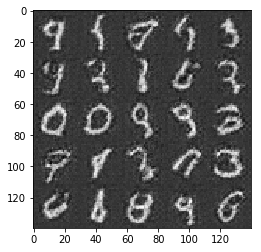

Epoch 2/2... Batch 510/1875... Discriminator Loss: 0.2016... Generator Loss: 1.9893
Epoch 2/2... Batch 520/1875... Discriminator Loss: 0.1802... Generator Loss: 2.4520
Epoch 2/2... Batch 530/1875... Discriminator Loss: 0.3470... Generator Loss: 1.6264
Epoch 2/2... Batch 540/1875... Discriminator Loss: 0.4623... Generator Loss: 1.4378
Epoch 2/2... Batch 550/1875... Discriminator Loss: 0.1334... Generator Loss: 2.5042
Epoch 2/2... Batch 560/1875... Discriminator Loss: 0.1334... Generator Loss: 2.6701
Epoch 2/2... Batch 570/1875... Discriminator Loss: 0.2407... Generator Loss: 1.8673
Epoch 2/2... Batch 580/1875... Discriminator Loss: 0.2660... Generator Loss: 1.7154
Epoch 2/2... Batch 590/1875... Discriminator Loss: 0.0664... Generator Loss: 3.2463
Epoch 2/2... Batch 600/1875... Discriminator Loss: 0.3268... Generator Loss: 1.5310


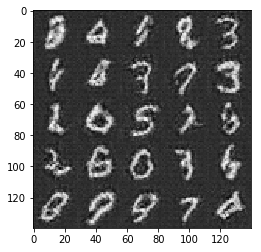

Epoch 2/2... Batch 610/1875... Discriminator Loss: 0.1272... Generator Loss: 2.3884
Epoch 2/2... Batch 620/1875... Discriminator Loss: 0.3727... Generator Loss: 1.4427
Epoch 2/2... Batch 630/1875... Discriminator Loss: 0.1883... Generator Loss: 2.1047
Epoch 2/2... Batch 640/1875... Discriminator Loss: 0.0691... Generator Loss: 4.9179
Epoch 2/2... Batch 650/1875... Discriminator Loss: 0.7321... Generator Loss: 1.4174
Epoch 2/2... Batch 660/1875... Discriminator Loss: 0.8288... Generator Loss: 0.8242
Epoch 2/2... Batch 670/1875... Discriminator Loss: 0.7541... Generator Loss: 2.8181
Epoch 2/2... Batch 680/1875... Discriminator Loss: 0.7094... Generator Loss: 3.1945
Epoch 2/2... Batch 690/1875... Discriminator Loss: 0.5806... Generator Loss: 1.1905
Epoch 2/2... Batch 700/1875... Discriminator Loss: 0.4890... Generator Loss: 1.6064


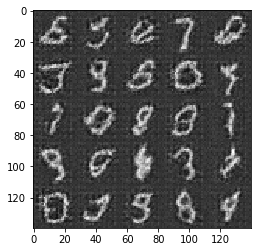

Epoch 2/2... Batch 710/1875... Discriminator Loss: 1.0532... Generator Loss: 0.6157
Epoch 2/2... Batch 720/1875... Discriminator Loss: 1.5655... Generator Loss: 0.3148
Epoch 2/2... Batch 730/1875... Discriminator Loss: 0.2909... Generator Loss: 2.5198
Epoch 2/2... Batch 740/1875... Discriminator Loss: 0.5165... Generator Loss: 1.3709
Epoch 2/2... Batch 750/1875... Discriminator Loss: 0.2382... Generator Loss: 3.1222
Epoch 2/2... Batch 760/1875... Discriminator Loss: 0.6848... Generator Loss: 0.9678
Epoch 2/2... Batch 770/1875... Discriminator Loss: 0.8417... Generator Loss: 0.9188
Epoch 2/2... Batch 780/1875... Discriminator Loss: 1.0018... Generator Loss: 0.6421
Epoch 2/2... Batch 790/1875... Discriminator Loss: 0.1250... Generator Loss: 2.9711
Epoch 2/2... Batch 800/1875... Discriminator Loss: 0.2394... Generator Loss: 1.8664


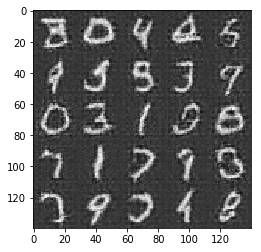

Epoch 2/2... Batch 810/1875... Discriminator Loss: 0.1055... Generator Loss: 2.8050
Epoch 2/2... Batch 820/1875... Discriminator Loss: 0.0739... Generator Loss: 2.9945
Epoch 2/2... Batch 830/1875... Discriminator Loss: 0.1162... Generator Loss: 2.8111
Epoch 2/2... Batch 840/1875... Discriminator Loss: 0.0415... Generator Loss: 4.3641
Epoch 2/2... Batch 850/1875... Discriminator Loss: 0.3023... Generator Loss: 1.7483
Epoch 2/2... Batch 860/1875... Discriminator Loss: 0.0935... Generator Loss: 3.4041
Epoch 2/2... Batch 870/1875... Discriminator Loss: 0.0292... Generator Loss: 4.2892
Epoch 2/2... Batch 880/1875... Discriminator Loss: 0.0813... Generator Loss: 3.2100
Epoch 2/2... Batch 890/1875... Discriminator Loss: 0.1233... Generator Loss: 2.4669
Epoch 2/2... Batch 900/1875... Discriminator Loss: 0.0405... Generator Loss: 4.1088


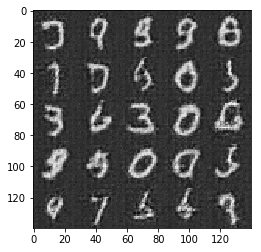

Epoch 2/2... Batch 910/1875... Discriminator Loss: 0.2088... Generator Loss: 2.0692
Epoch 2/2... Batch 920/1875... Discriminator Loss: 0.0691... Generator Loss: 3.4007
Epoch 2/2... Batch 930/1875... Discriminator Loss: 0.2413... Generator Loss: 1.9111
Epoch 2/2... Batch 940/1875... Discriminator Loss: 0.1074... Generator Loss: 2.7724
Epoch 2/2... Batch 950/1875... Discriminator Loss: 0.0449... Generator Loss: 4.0906
Epoch 2/2... Batch 960/1875... Discriminator Loss: 0.1224... Generator Loss: 2.6948
Epoch 2/2... Batch 970/1875... Discriminator Loss: 0.0132... Generator Loss: 5.5524
Epoch 2/2... Batch 980/1875... Discriminator Loss: 0.3903... Generator Loss: 1.3197
Epoch 2/2... Batch 990/1875... Discriminator Loss: 0.0976... Generator Loss: 3.0386
Epoch 2/2... Batch 1000/1875... Discriminator Loss: 0.0479... Generator Loss: 4.1116


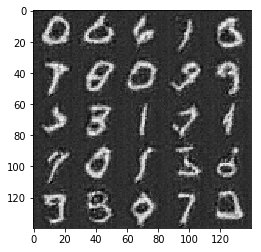

Epoch 2/2... Batch 1010/1875... Discriminator Loss: 0.1058... Generator Loss: 2.6866
Epoch 2/2... Batch 1020/1875... Discriminator Loss: 0.2128... Generator Loss: 2.1581
Epoch 2/2... Batch 1030/1875... Discriminator Loss: 0.0701... Generator Loss: 3.6164
Epoch 2/2... Batch 1040/1875... Discriminator Loss: 0.0373... Generator Loss: 3.9172
Epoch 2/2... Batch 1050/1875... Discriminator Loss: 0.0324... Generator Loss: 4.1609
Epoch 2/2... Batch 1060/1875... Discriminator Loss: 0.0268... Generator Loss: 4.4272
Epoch 2/2... Batch 1070/1875... Discriminator Loss: 0.1353... Generator Loss: 2.5810
Epoch 2/2... Batch 1080/1875... Discriminator Loss: 0.4164... Generator Loss: 1.7314
Epoch 2/2... Batch 1090/1875... Discriminator Loss: 1.2928... Generator Loss: 0.7073
Epoch 2/2... Batch 1100/1875... Discriminator Loss: 0.4293... Generator Loss: 3.1349


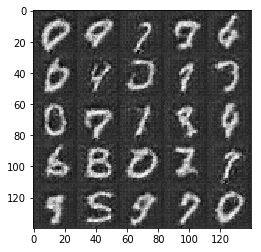

Epoch 2/2... Batch 1110/1875... Discriminator Loss: 0.3662... Generator Loss: 1.6373
Epoch 2/2... Batch 1120/1875... Discriminator Loss: 0.4436... Generator Loss: 2.2909
Epoch 2/2... Batch 1130/1875... Discriminator Loss: 0.3155... Generator Loss: 2.5933
Epoch 2/2... Batch 1140/1875... Discriminator Loss: 0.2347... Generator Loss: 2.3282
Epoch 2/2... Batch 1150/1875... Discriminator Loss: 0.2630... Generator Loss: 2.0185
Epoch 2/2... Batch 1160/1875... Discriminator Loss: 0.3924... Generator Loss: 1.4871
Epoch 2/2... Batch 1170/1875... Discriminator Loss: 0.3365... Generator Loss: 1.7920
Epoch 2/2... Batch 1180/1875... Discriminator Loss: 0.6079... Generator Loss: 1.1599
Epoch 2/2... Batch 1190/1875... Discriminator Loss: 0.2571... Generator Loss: 2.0123
Epoch 2/2... Batch 1200/1875... Discriminator Loss: 0.1785... Generator Loss: 2.1899


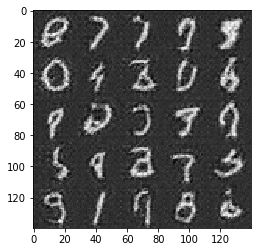

Epoch 2/2... Batch 1210/1875... Discriminator Loss: 0.1856... Generator Loss: 2.5040
Epoch 2/2... Batch 1220/1875... Discriminator Loss: 0.4311... Generator Loss: 1.3168
Epoch 2/2... Batch 1230/1875... Discriminator Loss: 0.1503... Generator Loss: 2.3048
Epoch 2/2... Batch 1240/1875... Discriminator Loss: 0.4288... Generator Loss: 1.2473
Epoch 2/2... Batch 1250/1875... Discriminator Loss: 0.0625... Generator Loss: 3.5098
Epoch 2/2... Batch 1260/1875... Discriminator Loss: 0.2606... Generator Loss: 1.8562
Epoch 2/2... Batch 1270/1875... Discriminator Loss: 0.1485... Generator Loss: 2.4352
Epoch 2/2... Batch 1280/1875... Discriminator Loss: 0.1476... Generator Loss: 2.3240
Epoch 2/2... Batch 1290/1875... Discriminator Loss: 0.1358... Generator Loss: 2.7253
Epoch 2/2... Batch 1300/1875... Discriminator Loss: 0.1816... Generator Loss: 2.3021


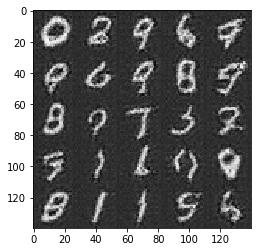

Epoch 2/2... Batch 1310/1875... Discriminator Loss: 0.1647... Generator Loss: 2.2563
Epoch 2/2... Batch 1320/1875... Discriminator Loss: 4.5957... Generator Loss: 6.4069
Epoch 2/2... Batch 1330/1875... Discriminator Loss: 1.4280... Generator Loss: 2.1421
Epoch 2/2... Batch 1340/1875... Discriminator Loss: 1.1159... Generator Loss: 0.6228
Epoch 2/2... Batch 1350/1875... Discriminator Loss: 1.4431... Generator Loss: 0.4981
Epoch 2/2... Batch 1360/1875... Discriminator Loss: 1.0971... Generator Loss: 1.8061
Epoch 2/2... Batch 1370/1875... Discriminator Loss: 0.7480... Generator Loss: 1.9224
Epoch 2/2... Batch 1380/1875... Discriminator Loss: 0.6995... Generator Loss: 1.7836
Epoch 2/2... Batch 1390/1875... Discriminator Loss: 1.1561... Generator Loss: 2.7851
Epoch 2/2... Batch 1400/1875... Discriminator Loss: 0.4359... Generator Loss: 1.9374


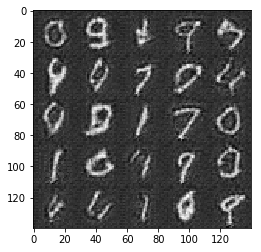

Epoch 2/2... Batch 1410/1875... Discriminator Loss: 0.4465... Generator Loss: 1.8071
Epoch 2/2... Batch 1420/1875... Discriminator Loss: 0.7990... Generator Loss: 2.9874
Epoch 2/2... Batch 1430/1875... Discriminator Loss: 0.4844... Generator Loss: 1.5422
Epoch 2/2... Batch 1440/1875... Discriminator Loss: 0.9962... Generator Loss: 4.7509
Epoch 2/2... Batch 1450/1875... Discriminator Loss: 0.4550... Generator Loss: 2.0872
Epoch 2/2... Batch 1460/1875... Discriminator Loss: 0.6698... Generator Loss: 1.0520
Epoch 2/2... Batch 1470/1875... Discriminator Loss: 1.0892... Generator Loss: 4.9858
Epoch 2/2... Batch 1480/1875... Discriminator Loss: 0.6862... Generator Loss: 0.9205
Epoch 2/2... Batch 1490/1875... Discriminator Loss: 0.3513... Generator Loss: 1.5840
Epoch 2/2... Batch 1500/1875... Discriminator Loss: 0.2773... Generator Loss: 2.9440


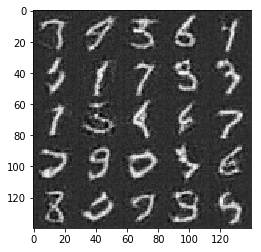

Epoch 2/2... Batch 1510/1875... Discriminator Loss: 0.2923... Generator Loss: 3.3559
Epoch 2/2... Batch 1520/1875... Discriminator Loss: 0.2053... Generator Loss: 2.1773
Epoch 2/2... Batch 1530/1875... Discriminator Loss: 0.9038... Generator Loss: 0.7285
Epoch 2/2... Batch 1540/1875... Discriminator Loss: 0.2969... Generator Loss: 1.7024
Epoch 2/2... Batch 1550/1875... Discriminator Loss: 0.2618... Generator Loss: 2.0837
Epoch 2/2... Batch 1560/1875... Discriminator Loss: 0.2130... Generator Loss: 2.2960
Epoch 2/2... Batch 1570/1875... Discriminator Loss: 0.1677... Generator Loss: 2.3034
Epoch 2/2... Batch 1580/1875... Discriminator Loss: 0.8177... Generator Loss: 0.8588
Epoch 2/2... Batch 1590/1875... Discriminator Loss: 0.2330... Generator Loss: 2.1516
Epoch 2/2... Batch 1600/1875... Discriminator Loss: 0.6606... Generator Loss: 0.9588


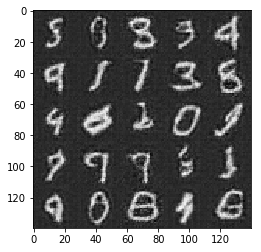

Epoch 2/2... Batch 1610/1875... Discriminator Loss: 0.1763... Generator Loss: 2.2649
Epoch 2/2... Batch 1620/1875... Discriminator Loss: 0.2035... Generator Loss: 1.9571
Epoch 2/2... Batch 1630/1875... Discriminator Loss: 0.1835... Generator Loss: 2.1642
Epoch 2/2... Batch 1640/1875... Discriminator Loss: 0.1237... Generator Loss: 2.8338
Epoch 2/2... Batch 1650/1875... Discriminator Loss: 0.2411... Generator Loss: 1.8384
Epoch 2/2... Batch 1660/1875... Discriminator Loss: 0.1754... Generator Loss: 2.2160
Epoch 2/2... Batch 1670/1875... Discriminator Loss: 0.1971... Generator Loss: 2.1118
Epoch 2/2... Batch 1680/1875... Discriminator Loss: 0.1932... Generator Loss: 2.1611
Epoch 2/2... Batch 1690/1875... Discriminator Loss: 0.2150... Generator Loss: 2.0688
Epoch 2/2... Batch 1700/1875... Discriminator Loss: 0.3204... Generator Loss: 1.5974


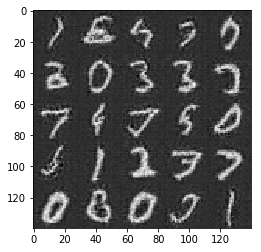

Epoch 2/2... Batch 1710/1875... Discriminator Loss: 0.0202... Generator Loss: 4.6871
Epoch 2/2... Batch 1720/1875... Discriminator Loss: 0.1134... Generator Loss: 2.8498
Epoch 2/2... Batch 1730/1875... Discriminator Loss: 0.0762... Generator Loss: 3.0552
Epoch 2/2... Batch 1740/1875... Discriminator Loss: 0.0548... Generator Loss: 3.4533
Epoch 2/2... Batch 1750/1875... Discriminator Loss: 0.1843... Generator Loss: 2.2715
Epoch 2/2... Batch 1760/1875... Discriminator Loss: 0.1228... Generator Loss: 2.7730
Epoch 2/2... Batch 1770/1875... Discriminator Loss: 0.0309... Generator Loss: 4.5176
Epoch 2/2... Batch 1780/1875... Discriminator Loss: 0.1689... Generator Loss: 2.3476
Epoch 2/2... Batch 1790/1875... Discriminator Loss: 0.1909... Generator Loss: 7.0264
Epoch 2/2... Batch 1800/1875... Discriminator Loss: 0.2062... Generator Loss: 2.2355


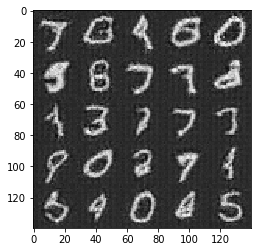

Epoch 2/2... Batch 1810/1875... Discriminator Loss: 0.1926... Generator Loss: 2.3439
Epoch 2/2... Batch 1820/1875... Discriminator Loss: 0.1572... Generator Loss: 2.3215
Epoch 2/2... Batch 1830/1875... Discriminator Loss: 0.1870... Generator Loss: 2.1946
Epoch 2/2... Batch 1840/1875... Discriminator Loss: 0.0420... Generator Loss: 3.7572
Epoch 2/2... Batch 1850/1875... Discriminator Loss: 0.1276... Generator Loss: 2.4570
Epoch 2/2... Batch 1860/1875... Discriminator Loss: 0.0246... Generator Loss: 4.3149
Epoch 2/2... Batch 1870/1875... Discriminator Loss: 1.0564... Generator Loss: 4.5426


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 100/6331... Discriminator Loss: 0.6484... Generator Loss: 1.0872
Epoch 1/1... Batch 200/6331... Discriminator Loss: 0.2557... Generator Loss: 2.0755
Epoch 1/1... Batch 300/6331... Discriminator Loss: 0.2376... Generator Loss: 3.2203
Epoch 1/1... Batch 400/6331... Discriminator Loss: 0.7357... Generator Loss: 0.7944
Epoch 1/1... Batch 500/6331... Discriminator Loss: 0.0308... Generator Loss: 4.3026


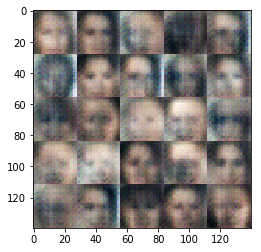

Epoch 1/1... Batch 600/6331... Discriminator Loss: 0.0080... Generator Loss: 11.1971
Epoch 1/1... Batch 700/6331... Discriminator Loss: 0.7719... Generator Loss: 11.8646
Epoch 1/1... Batch 800/6331... Discriminator Loss: 0.0834... Generator Loss: 2.8476
Epoch 1/1... Batch 900/6331... Discriminator Loss: 0.0264... Generator Loss: 4.6301
Epoch 1/1... Batch 1000/6331... Discriminator Loss: 0.1569... Generator Loss: 4.8418


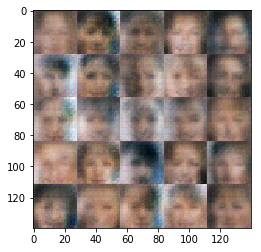

Epoch 1/1... Batch 1100/6331... Discriminator Loss: 0.8897... Generator Loss: 0.6399
Epoch 1/1... Batch 1200/6331... Discriminator Loss: 1.2876... Generator Loss: 11.1593
Epoch 1/1... Batch 1300/6331... Discriminator Loss: 0.0246... Generator Loss: 4.4559
Epoch 1/1... Batch 1400/6331... Discriminator Loss: 0.0042... Generator Loss: 6.8303
Epoch 1/1... Batch 1500/6331... Discriminator Loss: 0.8368... Generator Loss: 0.7148


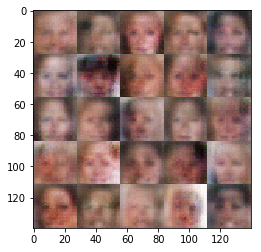

Epoch 1/1... Batch 1600/6331... Discriminator Loss: 0.0518... Generator Loss: 8.4956
Epoch 1/1... Batch 1700/6331... Discriminator Loss: 0.0036... Generator Loss: 12.9375
Epoch 1/1... Batch 1800/6331... Discriminator Loss: 0.1996... Generator Loss: 2.2161
Epoch 1/1... Batch 1900/6331... Discriminator Loss: 0.0054... Generator Loss: 6.8964
Epoch 1/1... Batch 2000/6331... Discriminator Loss: 0.0813... Generator Loss: 3.4164


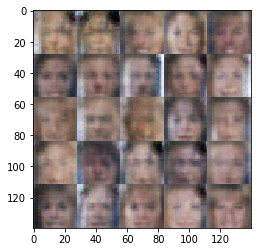

Epoch 1/1... Batch 2100/6331... Discriminator Loss: 0.0177... Generator Loss: 9.1298
Epoch 1/1... Batch 2200/6331... Discriminator Loss: 2.0889... Generator Loss: 0.3922
Epoch 1/1... Batch 2300/6331... Discriminator Loss: 0.0055... Generator Loss: 15.2616
Epoch 1/1... Batch 2400/6331... Discriminator Loss: 0.0070... Generator Loss: 9.1103
Epoch 1/1... Batch 2500/6331... Discriminator Loss: 0.0536... Generator Loss: 7.2421


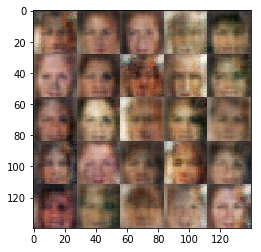

Epoch 1/1... Batch 2600/6331... Discriminator Loss: 0.0553... Generator Loss: 4.3902
Epoch 1/1... Batch 2700/6331... Discriminator Loss: 0.5809... Generator Loss: 1.0089
Epoch 1/1... Batch 2800/6331... Discriminator Loss: 0.2005... Generator Loss: 2.4736
Epoch 1/1... Batch 2900/6331... Discriminator Loss: 0.0138... Generator Loss: 7.0784
Epoch 1/1... Batch 3000/6331... Discriminator Loss: 0.0472... Generator Loss: 5.9522


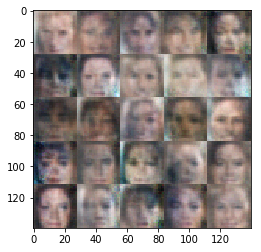

Epoch 1/1... Batch 3100/6331... Discriminator Loss: 0.1331... Generator Loss: 5.1010
Epoch 1/1... Batch 3200/6331... Discriminator Loss: 0.0973... Generator Loss: 6.1590
Epoch 1/1... Batch 3300/6331... Discriminator Loss: 0.0245... Generator Loss: 6.7290
Epoch 1/1... Batch 3400/6331... Discriminator Loss: 0.0480... Generator Loss: 6.5716
Epoch 1/1... Batch 3500/6331... Discriminator Loss: 0.0132... Generator Loss: 7.6745


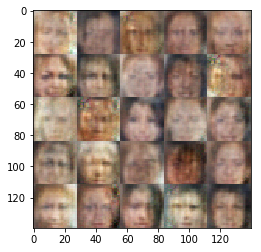

Epoch 1/1... Batch 3600/6331... Discriminator Loss: 2.0442... Generator Loss: 8.3937
Epoch 1/1... Batch 3700/6331... Discriminator Loss: 0.0981... Generator Loss: 6.7531
Epoch 1/1... Batch 3800/6331... Discriminator Loss: 0.2619... Generator Loss: 2.9078
Epoch 1/1... Batch 3900/6331... Discriminator Loss: 0.0082... Generator Loss: 6.5168
Epoch 1/1... Batch 4000/6331... Discriminator Loss: 2.5288... Generator Loss: 6.0449


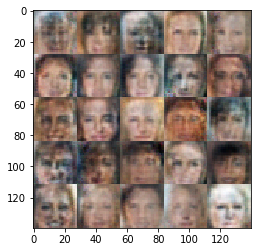

Epoch 1/1... Batch 4100/6331... Discriminator Loss: 0.3614... Generator Loss: 1.5126
Epoch 1/1... Batch 4200/6331... Discriminator Loss: 0.0255... Generator Loss: 10.0498
Epoch 1/1... Batch 4300/6331... Discriminator Loss: 0.7778... Generator Loss: 6.1465
Epoch 1/1... Batch 4400/6331... Discriminator Loss: 0.2299... Generator Loss: 2.8773
Epoch 1/1... Batch 4500/6331... Discriminator Loss: 0.1026... Generator Loss: 8.0206


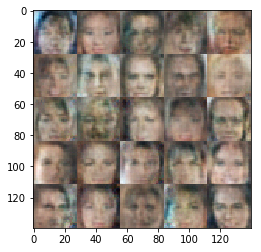

Epoch 1/1... Batch 4600/6331... Discriminator Loss: 0.2695... Generator Loss: 2.6839
Epoch 1/1... Batch 4700/6331... Discriminator Loss: 0.1101... Generator Loss: 4.9149
Epoch 1/1... Batch 4800/6331... Discriminator Loss: 0.0161... Generator Loss: 10.0661
Epoch 1/1... Batch 4900/6331... Discriminator Loss: 0.2119... Generator Loss: 3.2911
Epoch 1/1... Batch 5000/6331... Discriminator Loss: 0.0605... Generator Loss: 5.9540


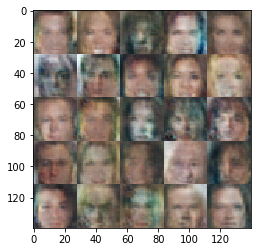

Epoch 1/1... Batch 5100/6331... Discriminator Loss: 0.1188... Generator Loss: 4.7685
Epoch 1/1... Batch 5200/6331... Discriminator Loss: 0.0313... Generator Loss: 6.1545
Epoch 1/1... Batch 5300/6331... Discriminator Loss: 0.0796... Generator Loss: 10.8507
Epoch 1/1... Batch 5400/6331... Discriminator Loss: 0.2813... Generator Loss: 4.5808
Epoch 1/1... Batch 5500/6331... Discriminator Loss: 0.4338... Generator Loss: 1.7389


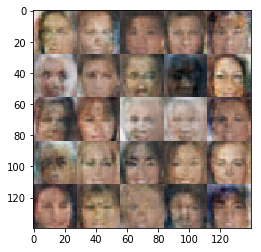

Epoch 1/1... Batch 5600/6331... Discriminator Loss: 0.0253... Generator Loss: 5.3724
Epoch 1/1... Batch 5700/6331... Discriminator Loss: 0.0810... Generator Loss: 5.5912
Epoch 1/1... Batch 5800/6331... Discriminator Loss: 0.9012... Generator Loss: 0.9361
Epoch 1/1... Batch 5900/6331... Discriminator Loss: 0.7149... Generator Loss: 4.9306
Epoch 1/1... Batch 6000/6331... Discriminator Loss: 0.0406... Generator Loss: 5.1620


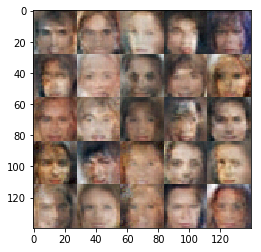

Epoch 1/1... Batch 6100/6331... Discriminator Loss: 0.2854... Generator Loss: 2.2384
Epoch 1/1... Batch 6200/6331... Discriminator Loss: 0.1729... Generator Loss: 3.3803
Epoch 1/1... Batch 6300/6331... Discriminator Loss: 0.0692... Generator Loss: 5.7036


In [33]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.